# Import

In [18]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, length, size, split, col, trim
from pyspark.sql.types import FloatType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
# import nltk
# nltk.download('punkt')  # For tokenization
# from nltk.stem import PorterStemmer
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import col, year
import numpy as np
# pd.set_osption('display.float_format', '{:.0f}'.format)

In [22]:
spark = SparkSession.builder \
    .appName("read_tsv") \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory', '32G') \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .config('spark.sql.shuffle.partitions', '500') \
    .config('spark.default.parallelism', '100') \
    .config('spark.serializer', 'org.apache.spark.serializer.KryoSerializer') \
    .config('spark.memory.fraction', '0.6') \
    .config('spark.memory.storageFraction', '0.5') \
    .getOrCreate()

In [23]:
# Read tsv file
data1 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Baby_v1_00.tsv", header=True, inferSchema=True)
data2 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Beauty_v1_00.tsv", header=True, inferSchema=True)
data3 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Camera_v1_00.tsv", header=True, inferSchema=True)
data4 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Electronics_v1_00.tsv", header=True, inferSchema=True)
data5 = spark.read.option("delimiter", "\t").csv("gs://msca-bdp-student-gcs/group10-amazon-review/amazon_reviews_us_Furniture_v1_00.tsv", header=True, inferSchema=True)

In [24]:
data = data1.union(data2).union(data3).union(data4).union(data5)

In [9]:
data.show(n=2)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|    9970739| R8EWA1OFT84NX|B00GSP5D94|     329991347|Summer Infant Swa...|            Baby|          5|            0|          0|   N|                Y|Great swaddled bl...|Loved these swadd...| 2015-08-31|
|         US|   23538442|R2JWY4YRQD4FOP|B00YYDDZGU|     646108902|Pacifier Clip Gir...|            Baby|          5|    

In [5]:
data.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [6]:
data.rdd.getNumPartitions()

55

## Data Cleaning

In [25]:
#data cleaning

from pyspark.sql.functions import col

#check any NA values
missing_count = [data.filter(col(customer_id).isNull()).count() for customer_id in data.columns]
missing_values = dict(zip(data.columns, missing_count))

# missing value counts
for column, count in missing_values.items():
    print(f"Missing values in '{column}': {count}")
    

#remove missing values
data_1 = data.dropna()

# Check for duplicates based on a column

data_dup = data_1.dropDuplicates(subset=["review_body", "review_id"])
# Count rows and see if duplicate rows were removed
data_dup.count()

from pyspark.sql.functions import length
data_text = data_dup.filter(length(data_dup["review_body"]) > 5)

# Count rows
data_text.count()


# convert to all lowercase text for consistency

from pyspark.sql.functions import lower
 
cols_lower = ["review_body", "product_title", "product_category","review_headline"]

# Apply lowercase conversion to each column
for col in cols_lower:
    data_text = data_text.withColumn(col, lower(data_text[col]))
    
    
#remove any unwanted characters

from pyspark.sql.functions import regexp_replace

cols_lower = ["review_body", "product_title", "product_category","review_headline"]

# Pattern for text cleaning
pattern = "[^a-zA-Z0-9\\s]"

# Apply text cleaning pattern to each column
for col in cols_lower:
    data_text = data_text.withColumn(col, regexp_replace(data_text[col], pattern, ""))


Missing values in 'marketplace': 0
Missing values in 'customer_id': 0
Missing values in 'review_id': 0
Missing values in 'product_id': 0
Missing values in 'product_parent': 0
Missing values in 'product_title': 0
Missing values in 'product_category': 223
Missing values in 'star_rating': 223
Missing values in 'helpful_votes': 224
Missing values in 'total_votes': 224
Missing values in 'vine': 224
Missing values in 'verified_purchase': 224
Missing values in 'review_headline': 237
Missing values in 'review_body': 1579
Missing values in 'review_date': 836


## Removing Stopwords

In [12]:
# Tokenize text
tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
df_tokens = tokenizer.transform(data_text)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
data_text = remover.transform(df_tokens)

In [11]:
data_text

23/11/27 20:51:31 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,words,filtered
US,10880255,R1Q4FWSAQIWZX8,B003Q6CUD0,847814827,cowon j3 32 gb po...,electronics,4,3,3,N,Y,be careful try i...,see update below...,2011-12-18,"[, see, update, b...","[, see, update, ,..."
US,42557174,R3FYPZ7KPFM3H5,B0013KW90K,730065402,philips aj260 wea...,electronics,4,17,17,N,N,my alltime favori...,update december ...,2008-09-06,"[, update, decemb...","[, update, decemb..."
US,53001767,R1M5DQQV3KU3TG,B0001B86GS,874497565,jvc grdx77 minidv...,camera,5,19,19,N,Y,great little camc...,update 42308 ...,2004-10-08,"[, , , , update, ...","[, , , , update, ..."
US,31930533,R3AA09RB7DBQQV,B00KYG674S,973989920,hosafe 1md1 10 me...,camera,4,15,17,N,Y,buyer beware,important these ...,2015-06-23,"[important, , the...","[important, , gre..."
US,35634317,R2SDN4QSP3Q54J,B005H2R4RI,321053641,prevention everyd...,beauty,1,0,0,N,N,2 the cost thru m...,2 the price my d...,2015-03-16,"[2, the, price, ,...","[2, price, , dent..."
US,40266180,R3IR6PKQTNCZXT,B003GLMW5Q,369998646,clean easy delux...,beauty,1,14,19,N,Y,negative,warning the item ...,2010-06-04,"[warning, the, it...","[warning, item, d..."
US,10325020,R27R9GM2YLUMGG,B003A7APTG,750901860,premium universal...,electronics,3,5,5,N,Y,know what youre b...,1if youre looking...,2012-05-05,"[1if, youre, look...","[1if, youre, look..."
US,34170916,R1M180GHQFEUKC,B00FRSM490,997745319,secret outlast xt...,beauty,5,0,0,N,N,a must try,gotitfreefromsecr...,2014-10-20,[gotitfreefromsec...,[gotitfreefromsec...
US,24110682,R19SFE5OLWI7IW,B0088RIV1W,927992098,cheetah mounts al...,furniture,5,1,1,N,Y,doesnt fit with p...,update they send ...,2014-09-20,"[update, they, se...","[update, send, ne..."
US,29504579,R3TY97HJ6YVMC9,B00FRSM490,997745319,secret outlast xt...,beauty,5,0,0,N,N,ready to roll,gotitfree thank y...,2014-11-04,"[gotitfree, thank...","[gotitfree, thank..."


# Text EDA

In [ ]:
# df_pd = data_text.toPandas()

In [12]:
data_text.dtypes

[('marketplace', 'string'),
 ('customer_id', 'int'),
 ('review_id', 'string'),
 ('product_id', 'string'),
 ('product_parent', 'int'),
 ('product_title', 'string'),
 ('product_category', 'string'),
 ('star_rating', 'string'),
 ('helpful_votes', 'int'),
 ('total_votes', 'int'),
 ('vine', 'string'),
 ('verified_purchase', 'string'),
 ('review_headline', 'string'),
 ('review_body', 'string'),
 ('review_date', 'string'),
 ('words', 'array<string>'),
 ('filtered', 'array<string>')]

In [13]:
data_text.describe()

summary,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
count,12412615,12412615,12412615,12412615,12412615,12412615,12412615,12412615,12412615,12412615,12412615,12412615,12412615,12412615,12412615
mean,null,2.761834696076282E7,null,5.703242334610844E9,5.05115562103148E8,Infinity,null,4.1264379826491036,1.9706808758670111,2.4697459801983705,null,null,NaN,1.118611267174697...,null
stddev,null,1.5371061660624683E7,null,3.9992273271292286E9,2.88703559872994E8,NaN,null,1.3253462698049485,19.156298509283072,20.349823756229217,null,null,NaN,1.006388821430035E15,null
min,US,10009,R10000T1NAVGE8,000004458X,377,,baby,1,0,0,N,N,,,1998-11-20
max,US,53096584,RZZZZVZTB4TQU,BT008V9J9U,999999319,zzzrt zz3000 j2 j...,furniture,5,13362,13636,Y,Y,zzzzzzzzzzzzzzzzz...,zzzzzzzzzzzzzzzzz...,2015-08-31


## Product Category Solds Visualization

In [11]:
# Group by 'product_category' and count
category_counts = data_text.groupBy("product_category").count()

# Show the result
category_counts.show()

+----------------+-------+
|product_category|  count|
+----------------+-------+
|          beauty|5045167|
|       furniture| 786952|
|     electronics|3061004|
|            baby|1735948|
|          camera|1783544|
+----------------+-------+



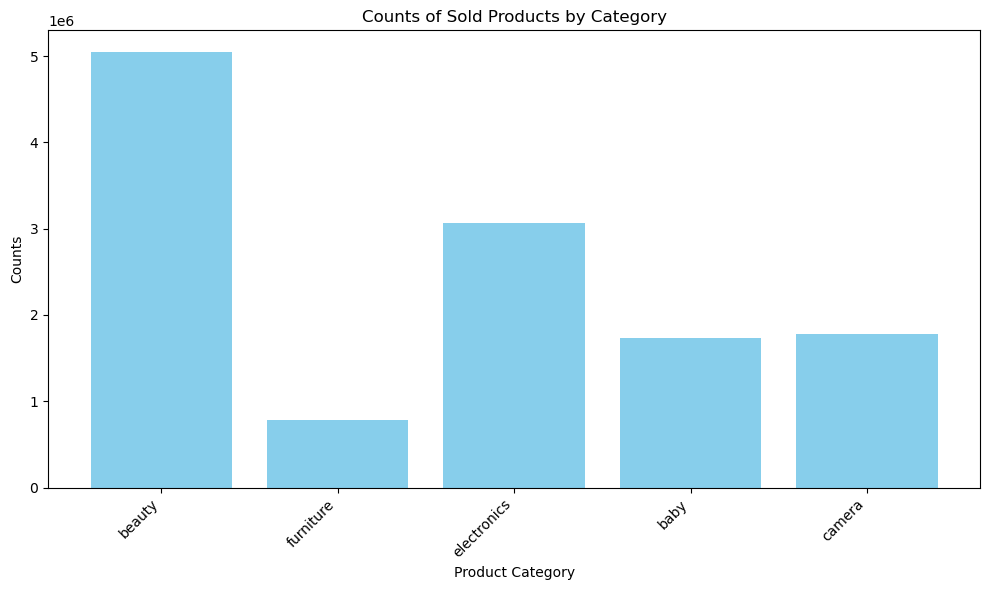

In [12]:
import matplotlib.pyplot as plt

# Collecting data to the driver
category_data = category_counts.collect()

# Preparing data for plotting
categories = [item['product_category'] for item in category_data]
counts = [item['count'] for item in category_data]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.xlabel('Product Category')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.title('Counts of Sold Products by Category')
plt.tight_layout()
plt.show()


In [15]:
# Extract year from 'review_date'
df_with_year = data_text.withColumn("year", year(col("review_date")))

# Group by 'product_category' and 'year', then count
category_yearly_counts = df_with_year.groupBy("product_category", "year").count()

# Show the result
category_yearly_counts.show()

+----------------+----+------+
|product_category|year| count|
+----------------+----+------+
|          beauty|2009| 57245|
|          camera|2014|457935|
|       furniture|2014|251524|
|          camera|2012|160564|
|       furniture|2009|  6861|
|          camera|2000|  3061|
|       furniture|2013|157414|
|            baby|2011|104458|
|            baby|2002|  6759|
|          beauty|2010| 95324|
|          beauty|2005|  7889|
|            baby|2015|493320|
|     electronics|2006| 29574|
|            baby|2012|141787|
|       furniture|2002|    69|
|       furniture|2003|   640|
|          beauty|2002|   567|
|          camera|2008| 49053|
|     electronics|2001|  5481|
|          beauty|2011|180728|
+----------------+----+------+
only showing top 20 rows



In [16]:
# Collecting data to the driver
category_year_data = category_yearly_counts.collect()

# Preparing data for plotting
categories = sorted(set(item['product_category'] for item in category_year_data))
years = sorted(set(item['year'] for item in category_year_data))

# Initialize a dictionary to store counts
count_dict = {(category, year): 0 for category in categories for year in years}

# Populate the dictionary with counts
for item in category_year_data:
    count_dict[(item['product_category'], item['year'])] = item['count']

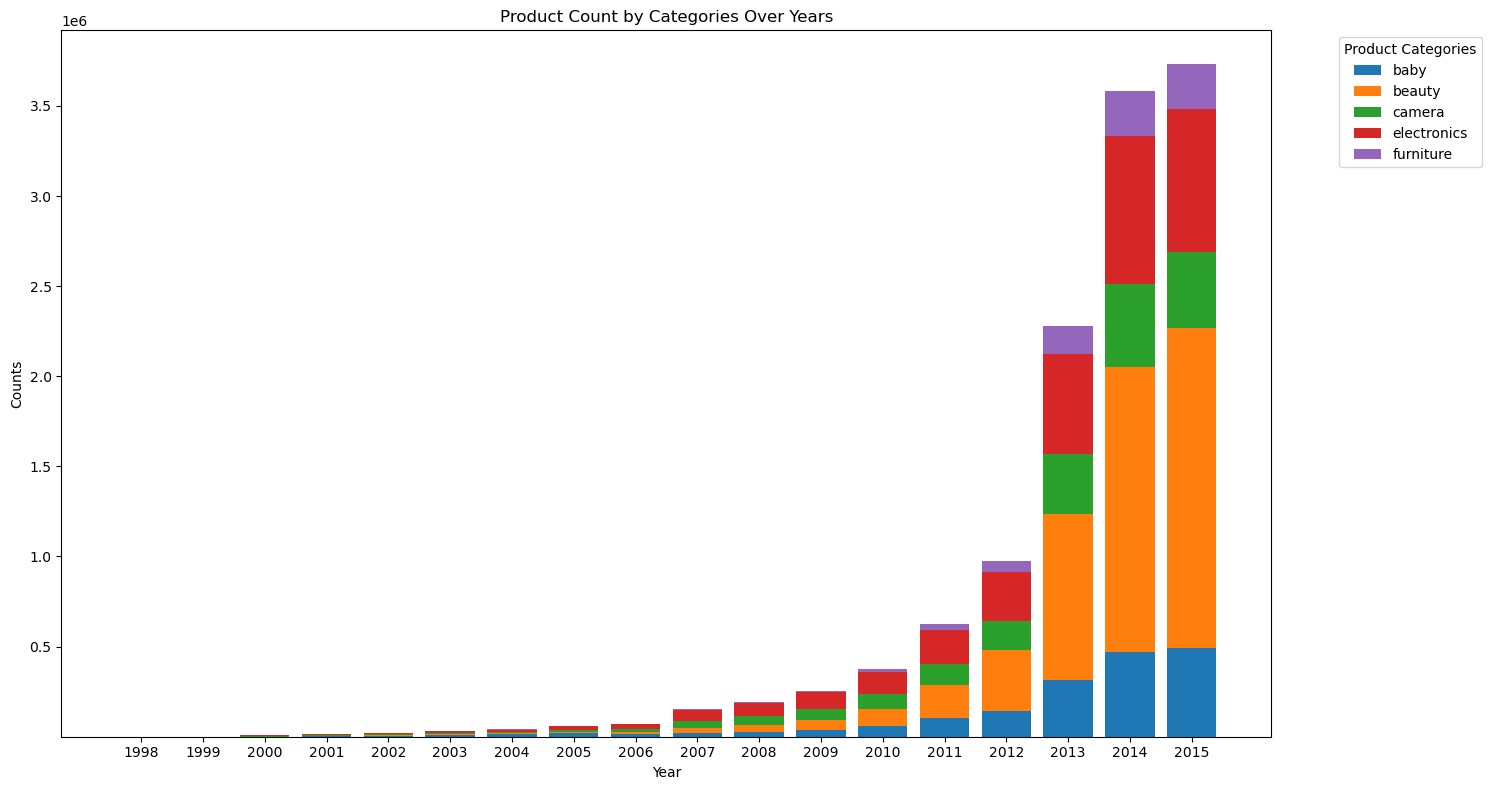

In [19]:
# Preparing data for stacked bar chart
counts_per_category = {category: [count_dict[(category, year)] for year in years] for category in categories}

# Plotting
plt.figure(figsize=(15, 8))

bottom = np.zeros(len(years))
for category in categories:
    plt.bar(years, counts_per_category[category], bottom=bottom, label=category)
    bottom += np.array(counts_per_category[category])

plt.xlabel('Year')
plt.ylabel('Counts')
plt.title('Product Count by Categories Over Years')
plt.xticks(years)
plt.legend(title='Product Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [20]:
# Sort and organize the data for plotting
data_dict = {}
for row in category_year_data:
    category = row['product_category']
    year = row['year']
    count = row['count']
    if category not in data_dict:
        data_dict[category] = {}
    data_dict[category][year] = count

# Ensure all categories have an entry for each year
years = sorted({row['year'] for row in category_year_data})
for category in data_dict.keys():
    for year in years:
        if year not in data_dict[category]:
            data_dict[category][year] = 0


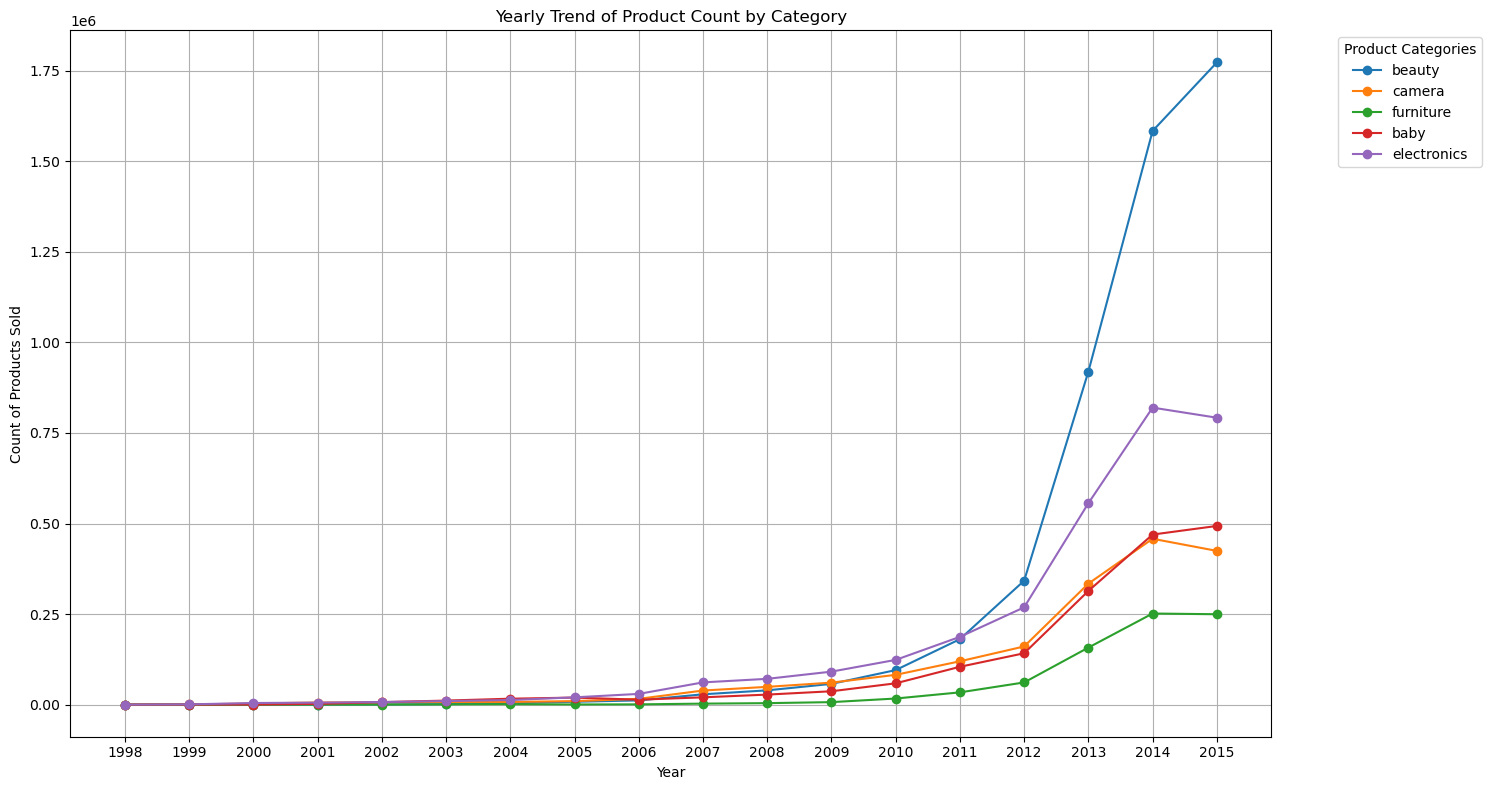

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Plotting a line for each category
for category, counts in data_dict.items():
    sorted_counts = [counts[year] for year in sorted(counts)]
    plt.plot(years, sorted_counts, label=category, marker='o')

plt.xlabel('Year')
plt.ylabel('Count of Products Sold')
plt.title('Yearly Trend of Product Count by Category')
plt.xticks(years)
plt.legend(title='Product Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Adding the length of the review and the word count of each review

In [7]:
from pyspark.sql.functions import length, size, split, col

# Assuming 'data_text' is a DataFrame containing a column named 'review_body'
data_text = data_text.withColumn('review_len', length(col('review_body')))
data_text = data_text.withColumn('word_count', size(split(col('review_body'), ' ')))

In [15]:
data_text

marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,words,filtered,review_len,word_count
US,10880255,R1Q4FWSAQIWZX8,B003Q6CUD0,847814827,cowon j3 32 gb po...,electronics,4,3,3,N,Y,be careful try i...,see update below...,2011-12-18,"[, see, update, b...","[, see, update, ,...",1012,209
US,42557174,R3FYPZ7KPFM3H5,B0013KW90K,730065402,philips aj260 wea...,electronics,4,17,17,N,N,my alltime favori...,update december ...,2008-09-06,"[, update, decemb...","[, update, decemb...",2562,478
US,53001767,R1M5DQQV3KU3TG,B0001B86GS,874497565,jvc grdx77 minidv...,camera,5,19,19,N,Y,great little camc...,update 42308 ...,2004-10-08,"[, , , , update, ...","[, , , , update, ...",2390,527
US,31930533,R3AA09RB7DBQQV,B00KYG674S,973989920,hosafe 1md1 10 me...,camera,4,15,17,N,Y,buyer beware,important these ...,2015-06-23,"[important, , the...","[important, , gre...",851,173
US,35634317,R2SDN4QSP3Q54J,B005H2R4RI,321053641,prevention everyd...,beauty,1,0,0,N,N,2 the cost thru m...,2 the price my d...,2015-03-16,"[2, the, price, ,...","[2, price, , dent...",31,7
US,40266180,R3IR6PKQTNCZXT,B003GLMW5Q,369998646,clean easy delux...,beauty,1,14,19,N,Y,negative,warning the item ...,2010-06-04,"[warning, the, it...","[warning, item, d...",1386,268
US,10325020,R27R9GM2YLUMGG,B003A7APTG,750901860,premium universal...,electronics,3,5,5,N,Y,know what youre b...,1if youre looking...,2012-05-05,"[1if, youre, look...","[1if, youre, look...",924,180
US,34170916,R1M180GHQFEUKC,B00FRSM490,997745319,secret outlast xt...,beauty,5,0,0,N,N,a must try,gotitfreefromsecr...,2014-10-20,[gotitfreefromsec...,[gotitfreefromsec...,297,53
US,24110682,R19SFE5OLWI7IW,B0088RIV1W,927992098,cheetah mounts al...,furniture,5,1,1,N,Y,doesnt fit with p...,update they send ...,2014-09-20,"[update, they, se...","[update, send, ne...",533,110
US,29504579,R3TY97HJ6YVMC9,B00FRSM490,997745319,secret outlast xt...,beauty,5,0,0,N,N,ready to roll,gotitfree thank y...,2014-11-04,"[gotitfree, thank...","[gotitfree, thank...",250,54


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# Convert PySpark DataFrame to Pandas DataFrame
data_text_pandas = data_text.toPandas()
data_text_pandas['star_rating'] = pd.to_numeric(data_text_pandas['star_rating'], errors='coerce')
data_text_pandas = data_text_pandas.sort_values(by='star_rating', ascending=True)

23/11/29 01:24:40 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


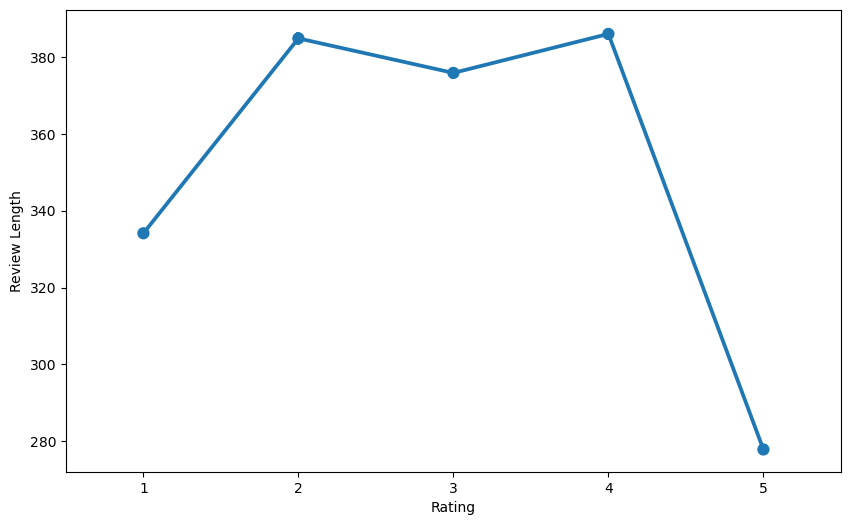

In [10]:
# Now you can use Seaborn with the Pandas DataFrame
plt.figure(figsize=(10, 6))
sns.pointplot(x="star_rating", y="review_len", data=data_text_pandas)
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.show()

When the rating is 5, review length significantly goes down. So, when customers were happy, they didn’t write too much

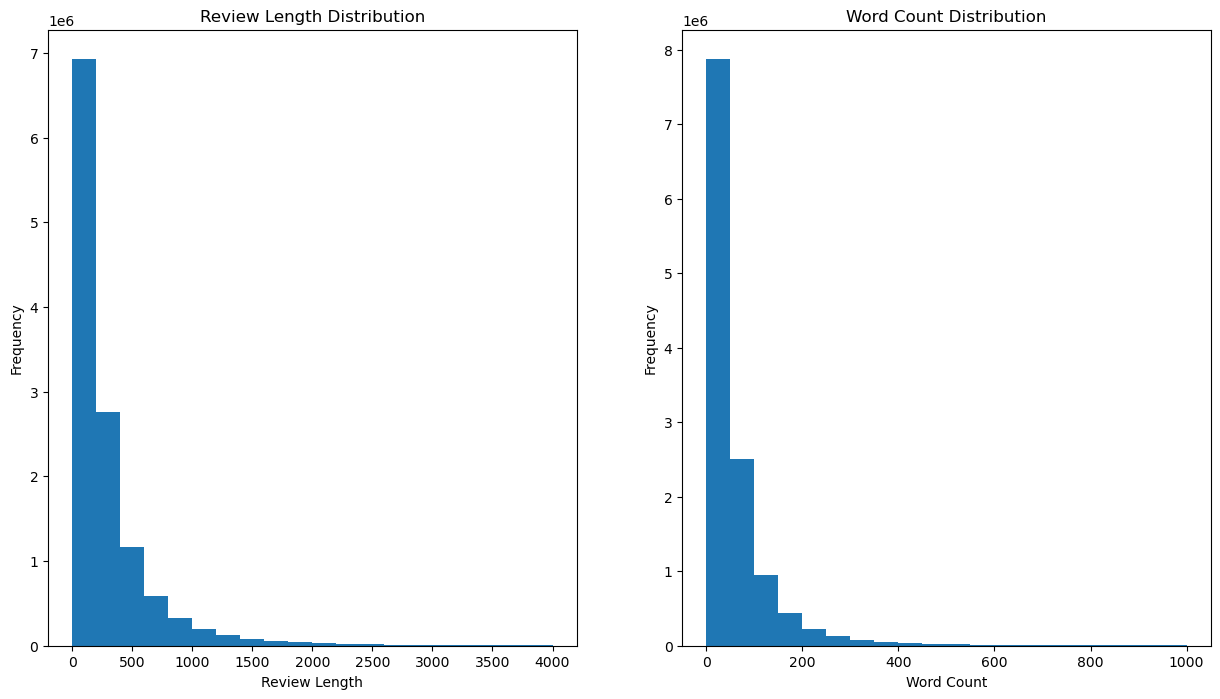

In [18]:
# Now collect the data - this brings the data to the driver, be careful with large datasets
review_len_data = data_text.select('review_len').rdd.flatMap(lambda x: x).collect()
word_count_data = data_text.select('word_count').rdd.flatMap(lambda x: x).collect()

# Create the histograms using matplotlib
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot histogram for review lengths
axs[0].hist(review_len_data, bins=20, range=(0, 4000))
axs[0].set_title('Review Length Distribution')
axs[0].set_xlabel('Review Length')
axs[0].set_ylabel('Frequency')

# Plot histogram for word counts
axs[1].hist(word_count_data, bins=20, range=(0, 1000))
axs[1].set_title('Word Count Distribution')
axs[1].set_xlabel('Word Count')
axs[1].set_ylabel('Frequency')

# Show the plots
plt.show()

In [14]:
data_text.count()

12412615

## Top 20 words

### Word Frequency Analysis
#### Count the most common words:

In [18]:
data_text.show(2)

23/11/27 22:05:40 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+--------------------+--------------------+----------+----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|               words|            filtered|review_len|word_count|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+--------------------+--------------------+----------+----------+
|         US|   10880255|R1Q4FWSAQIWZX8|B003Q6CUD0|     847814827|cowon j3 32 gb po...|     electronics|          4|            3|          3|   N| 

In [15]:
from pyspark.sql.functions import explode, count

df_word_freq = data_text.withColumn("word", explode(col("filtered"))) \
    .groupBy("word") \
    .count() \
    .filter(trim(col("word")) != "") \
    .sort(col("count").desc())

df_word_freq.show()

+-------+-------+
|   word|  count|
+-------+-------+
|  great|3724227|
|    one|3055032|
|product|3018325|
|    use|2968099|
|     br|2887296|
|   like|2749744|
|   good|2711681|
|   well|2002757|
|    get|1995453|
|   love|1993188|
| really|1749599|
|   hair|1686578|
| camera|1630655|
|   time|1623288|
|  works|1524618|
|   dont|1519589|
|  price|1506741|
|quality|1490273|
|   used|1444375|
|   also|1434961|
+-------+-------+
only showing top 20 rows



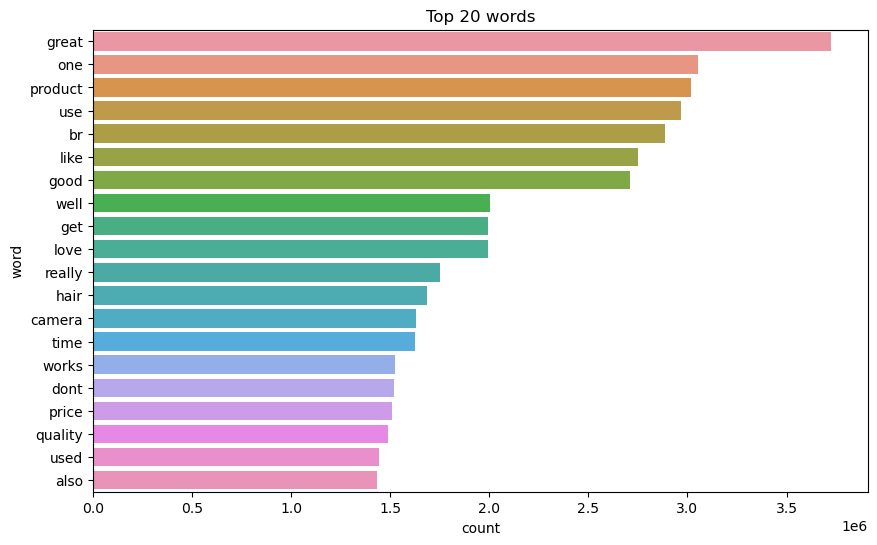

In [16]:
word_freq_pd = df_word_freq.limit(20).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=word_freq_pd)
plt.title('Top 20 words')
plt.show()

### N-Gram Analysis
##### To identify common phrases:

In [17]:
from pyspark.ml.feature import NGram

ngram = NGram(n=2, inputCol="filtered", outputCol="ngrams")
df_ngrams = ngram.transform(data_text)

df_ngrams_freq = df_ngrams.withColumn("ngram", explode(col("ngrams"))) \
    .groupBy("ngram") \
    .count() \
    .filter(trim(col("ngram")) != "") \
    .sort(col("count").desc())

df_ngrams_freq.show()

+----------------+------+
|           ngram| count|
+----------------+------+
|     works great|362084|
|   great product|297160|
|            also|283919|
|highly recommend|255915|
|      works well|246531|
|        easy use|233630|
|   sound quality|230758|
|             br |229351|
|           great|220211|
|        product |213679|
|          great |196726|
|              br|196543|
|            love|190725|
|              im|181931|
|            dont|178942|
|             one|171600|
|     great price|168896|
|     much better|168554|
|             use|167177|
|           well |166608|
+----------------+------+
only showing top 20 rows



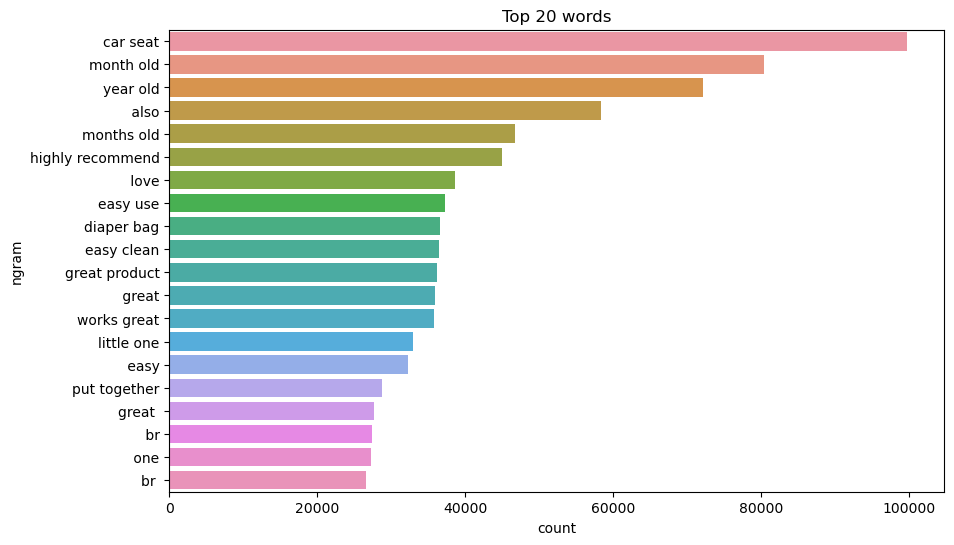

In [39]:
word_ngrams_pd = df_ngrams_freq.limit(20).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='ngram', data=word_ngrams_pd)
plt.title('Top 20 words')
plt.show()

In [19]:
ngram = NGram(n=3, inputCol="filtered", outputCol="trigrams")
df_trigrams = ngram.transform(data_text)

# Explode the trigrams into a new row for each trigram
df_exploded_trigrams = df_trigrams.select(explode(col("trigrams")).alias("trigram"))

# Group by the trigram and count occurrences
df_trigram_freq = df_exploded_trigrams.groupBy("trigram").count().filter(trim(col("trigram")) != "").orderBy(col("count").desc())

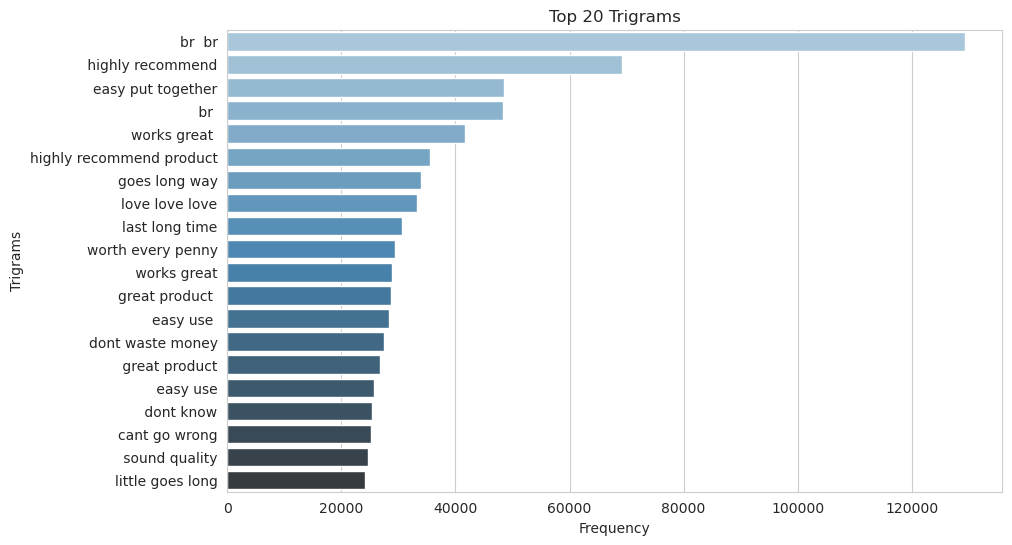

In [20]:
# Collect data for visualization
top_trigrams = df_trigram_freq.limit(20).toPandas()

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(10, 6))

# Plot the top trigrams
sns.barplot(x="count", y="trigram", data=top_trigrams, palette="Blues_d")

# Add labels and title
plt.xlabel("Frequency")
plt.ylabel("Trigrams")
plt.title("Top 20 Trigrams")

# Show the plot
plt.show()

In [53]:
import regex
print(hasattr(regex, 'Pattern'))  # This should print True if the installation is correct


True


### Part-of-Speech Tagging

In [ ]:
import nltk
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

nltk.download('averaged_perceptron_tagger')

# Define a UDF to tag parts of speech
@udf(returnType=ArrayType(StringType()))
def pos_tagger(sentence):
    return [pair[1] for pair in nltk.pos_tag(nltk.word_tokenize(sentence))]

df_with_pos = data_text.withColumn('pos_tags', pos_tagger(col('filtered')))
df_with_pos.show()

### TF-IDF

#### Review body analysis

In [17]:
from pyspark.ml.feature import HashingTF, IDF

# # Tokenizing the text
# tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
# df_words = tokenizer.transform(data_text)

# Applying HashingTF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures")
df_featurized = hashingTF.transform(df_tokens)

# Calculating the IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_featurized)
df_rescaled = idfModel.transform(df_featurized)

df_rescaled.select("review_body", "features").show()

23/11/07 15:58:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+--------------------+--------------------+
|         review_body|            features|
+--------------------+--------------------+
|comfortable mattr...|(262144,[3121,592...|
|    used for 2 years|(262144,[12524,76...|
|this works very w...|(262144,[9056,190...|
|       great quality|(262144,[43890,26...|
|this head rest di...|(262144,[3924,252...|
|the blanket is so...|(262144,[6346,125...|
|the elastic pocke...|(262144,[2019,331...|
|there are much be...|(262144,[4629,995...|
|the material is n...|(262144,[3121,777...|
|this saved my bab...|(262144,[19036,21...|
|love this camera ...|(262144,[58267,71...|
|love it wish i co...|(262144,[8421,125...|
|works perfectly m...|(262144,[11223,19...|
|compared to the o...|(262144,[1968,232...|
|fantastic bag too...|(262144,[5163,592...|
|   just as described|(262144,[97171,19...|
|it works as descr...|(262144,[30950,18...|
|great chair  weve...|(262144,[30950,31...|
|we received this ...|(262144,[415,4629...|
|       great product|(262144,[5

#### Review Title analysis

In [25]:
tokenizer = Tokenizer(inputCol="review_headline", outputCol="words_headline")
df_tokens_title = tokenizer.transform(data_text)

hashingTF = HashingTF(inputCol="words_headline", outputCol="rawFeatures")
df_featurized = hashingTF.transform(df_tokens_title)

# Calculating the IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_featurized)
df_rescaled_headline = idfModel.transform(df_featurized)

df_rescaled_headline.select("review_headline", "features").show()

23/11/07 16:36:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB


+--------------------+--------------------+
|     review_headline|            features|
+--------------------+--------------------+
|           i love it|(262144,[19036,30...|
|decent product bu...|(262144,[5923,339...|
|my 7 month olds f...|(262144,[49783,75...|
|1 ur saving a ton...|(262144,[19036,24...|
|1 200 hundred dol...|(262144,[4978,275...|
|use 6 ping pong b...|(262144,[68647,86...|
|way to0 expensive...|(262144,[19352,51...|
|       180 seriously|(262144,[178915,2...|
|great value for p...|(262144,[106776,1...|
|             bad bad|(262144,[145380],...|
|you have to be ki...|(262144,[17373,27...|
|   great doggie bags|(262144,[23654,12...|
|5 58 on alvas web...|(262144,[67416,10...|
|            one star|(262144,[21823,21...|
|expensive doesnt ...|(262144,[5227,193...|
|you can buy this ...|(262144,[67562,73...|
|   is this a mistake|(262144,[17046,10...|
|dollar store product|(262144,[52879,20...|
|     worth the money|(262144,[51247,95...|
|the quality is ex...|(262144,[4

### Topic Modeling

#### Review Body analysis

In [18]:
from pyspark.ml.clustering import LDA

# Assume the TF-IDF features are already computed in df_rescaled
lda = LDA(k=10, maxIter=10, featuresCol="features")
model = lda.fit(df_rescaled)

# Shows the result
topics = model.describeTopics()
topics.show()

# Transform the data. This adds a topicDistribution column
transformed = model.transform(df_rescaled)
transformed.show()

23/11/07 16:11:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/07 16:12:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/07 16:12:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/07 16:12:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 44.1 MiB
23/11/07 16:13:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 64.1 MiB
23/11/07 16:13:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/07 16:13:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 44.1 MiB
23/11/07 16:13:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 64.1 MiB
23/11/07 16:13:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bina

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[249180, 19036, 9...|[0.00838530702849...|
|    1|[249180, 230277, ...|[0.00867667095646...|
|    2|[249180, 259145, ...|[0.00628042869381...|
|    3|[249180, 19036, 9...|[0.00900523155364...|
|    4|[249180, 95889, 2...|[0.00682370931621...|
|    5|[249180, 19036, 6...|[0.00390203828953...|
|    6|[249180, 32492, 9...|[0.00733401028045...|
|    7|[25615, 249180, 7...|[0.01161674188246...|
|    8|[92159, 249180, 9...|[0.00616783506177...|
|    9|[9788, 249180, 14...|[0.01760377367777...|
+-----+--------------------+--------------------+



23/11/07 16:15:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 24.1 MiB


+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|               words|         rawFeatures|            features|   topicDistribution|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|         US|   36520870|R3KKH2YB7VLJ88|B0026FBPC4|     247882308|britax marathon 6...| 

In [19]:
transformed.select("review_body", "features","topicDistribution").show()

23/11/07 16:17:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 24.1 MiB


+--------------------+--------------------+--------------------+
|         review_body|            features|   topicDistribution|
+--------------------+--------------------+--------------------+
|the inner lining ...|(262144,[1546,309...|[0.00131688838207...|
|great idea  unfor...|(262144,[27576,30...|[0.00108677620133...|
|    bought as a gift|(262144,[107107,1...|[0.90130832052223...|
|great booster cha...|(262144,[4629,125...|[0.00178461427257...|
|love love the nav...|(262144,[4379,137...|[0.00160360043876...|
|best baby purchas...|(262144,[9420,187...|[5.09596516236912...|
|loved these for a...|(262144,[12021,17...|[0.00173837450334...|
|didnt notice a ch...|(262144,[58267,10...|[0.00312379369105...|
|my twins were bot...|(262144,[1546,228...|[1.87435069992835...|
|          works well|(262144,[181321,1...|[0.01623958458539...|
|this rack was ok ...|(262144,[1546,905...|[0.37558028837267...|
|my kid just loves it|(262144,[5451,309...|[0.92016744200218...|
|nice car seat and...|(26

The document bought as a gift is predominantly associated with the first topic (probability 0.90130832052223...), meaning that based on its words, the LDA model thinks this document is about the first topic.
The document my kid just loves it is associated mostly with the second topic (probability 0.92016744200218...), indicating that this document is mainly about the second topic, according to the LDA model.

In [22]:
topics = model.describeTopics(maxTermsPerTopic=10)
topics.show(truncate=False)

+-----+------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                                   |termWeights                                                                                                                                                                                                                        |
+-----+------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[249180, 19036, 95889, 30950, 240944, 27576, 198

#### Review Title analysis

In [26]:
# Assume the TF-IDF features are already computed in df_rescaled
lda = LDA(k=10, maxIter=10, featuresCol="features")
model = lda.fit(df_rescaled)

# Shows the result
topics = model.describeTopics()
topics.show()

# Transform the data. This adds a topicDistribution column
transformed2 = model.transform(df_rescaled_headline)
transformed2.select("review_headline", "features","topicDistribution").show()

23/11/07 16:37:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/07 16:37:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/07 16:37:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/07 16:37:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 44.1 MiB
23/11/07 16:37:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 64.1 MiB
23/11/07 16:37:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/07 16:37:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 44.1 MiB
23/11/07 16:37:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 64.1 MiB
23/11/07 16:37:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bina

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[115398, 240944, ...|[0.02665195482842...|
|    1|[181321, 113432, ...|[0.02875111054675...|
|    2|[167301, 15585, 2...|[0.03293192868922...|
|    3|[186480, 30950, 2...|[0.02420871639607...|
|    4|[230406, 107107, ...|[0.01412404843041...|
|    5|[12710, 40082, 45...|[0.15857739738849...|
|    6|[93307, 213760, 4...|[0.02632222825429...|
|    7|[52879, 81566, 26...|[0.03806732086451...|
|    8|[21823, 27576, 96...|[0.01708946925684...|
|    9|[117491, 23837, 2...|[0.02754707881620...|
+-----+--------------------+--------------------+



23/11/07 16:38:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 24.1 MiB


+--------------------+--------------------+--------------------+
|     review_headline|            features|   topicDistribution|
+--------------------+--------------------+--------------------+
|           i love it|(262144,[19036,30...|[0.01051409527230...|
|decent product bu...|(262144,[5923,339...|[0.00180683463163...|
|my 7 month olds f...|(262144,[49783,75...|[0.25172615875214...|
|1 ur saving a ton...|(262144,[19036,24...|[0.20960094613001...|
|1 200 hundred dol...|(262144,[4978,275...|[0.00164476607337...|
|use 6 ping pong b...|(262144,[68647,86...|[0.00164103691087...|
|way to0 expensive...|(262144,[19352,51...|[0.26047063735664...|
|       180 seriously|(262144,[178915,2...|[0.00446090521900...|
|great value for p...|(262144,[106776,1...|[0.00635003270568...|
|             bad bad|(262144,[145380],...|[0.00808483828993...|
|you have to be ki...|(262144,[17373,27...|[0.00297074508986...|
|   great doggie bags|(262144,[23654,12...|[0.00496937733415...|
|5 58 on alvas web...|(26

In [33]:
product_pol = df_pd.groupby('product_title')['star_rating'].agg([np.mean])
product_pol.columns = ['star_rating']
product_pol = product_pol.sort_values('star_rating', ascending=False)
product_pol = product_pol.head(20)
product_pol

,star_rating
product_title,
zyhome best friends lover family pillowcase im 999 sure im a disney princess pillow sham throw pillow cushion case cover two sides printed 20x30 inches,5
isababies infant girls one piece bathing suit and coverup pink size 18months,5
iplay sof t snugglypastel chichi blue,5
iplay soft snuggly pastel chichi pink,5
iplay super sounds car keys,5
iplay winter wear fleece hat infant and toddler,5
ipood funny unisex boygirl baby grow vest,5
tuc tuc plush soft baby toy raccoon boy magic forest collection blue,5
tuc tuc pink stroller bunting bag universal footmuff snugle bag chip chip collection,5
